In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import tqdm
from scipy import sparse
import scipy
from sklearn.metrics.pairwise import cosine_similarity
from multiprocesspandas import applyparallel
from scipy.sparse import csr_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Чтение датасетов

In [3]:
df = pd.read_csv('with_new_ids_final.csv', engine='c')
df.drop(['user_id', 'event_date'], axis=1, inplace=True)
df

,event_timestamp,vacancy_id_,cookie_id,event_type,new_id
0,1659323026,129850,97990f1a021d4be19aa3f955b7eacab4,show_vacancy,951f53de61764ea0b51317200a0dbbfc
1,1659377255,108347,03bf8c511fa949c79845a5d81b09aa1d,show_vacancy,f5a2326a17484330aa8cb4019f1b1960
2,1659376695,109069,03bf8c511fa949c79845a5d81b09aa1d,show_vacancy,f5a2326a17484330aa8cb4019f1b1960
3,1659376722,171425,03bf8c511fa949c79845a5d81b09aa1d,show_vacancy,f5a2326a17484330aa8cb4019f1b1960
4,1659374929,252384,03bf8c511fa949c79845a5d81b09aa1d,show_vacancy,f5a2326a17484330aa8cb4019f1b1960
...,...,...,...,...,...
12182963,1660246479,162851,0d3c58c6864546c689fa0997de484b30,preview_click_response,18124998fd644e80b667a1d84bf63846
12182964,1660246106,136818,ef559274a81e4ff4b92aa3e9f6805886,preview_click_response,5c71c1f1b7cf492ba05871c400a05250
12182965,1660250139,143721,c4453128ae584dca8f2a8d20a7c74263,preview_click_response,33c968125459420e89ffbc8cffece317
12182966,1660250318,154423,c4453128ae584dca8f2a8d20a7c74263,preview_click_response,33c968125459420e89ffbc8cffece317


In [4]:
uniq_users_id = df['new_id'].unique()
uniq_vacancy = df['vacancy_id_'].unique()
users_cookies = df.groupby(['cookie_id'], as_index=False)['new_id'].agg(['unique'])

In [5]:
interactions = df.groupby(['new_id', 'vacancy_id_', 'event_type'], as_index=False) \
.agg({'event_timestamp': 'count'}) \
.sort_values(['event_timestamp'], ascending=False)

In [6]:
def get_new_id_by_cookie(cookie):
    return users_cookies.loc[cookie][0][0]

test_df = pd.read_parquet('test_public_mfti.parquet', engine='pyarrow')
test_df['cookie_id'] = test_df['cookie_id'].apply(lambda x: get_new_id_by_cookie(x))
test_df = test_df.rename(columns={'cookie_id': 'new_id'})

In [7]:
test_df

,new_id,vacancy_id_
0,477e719bfbcc4071a8acc1b357492b00,"[222177, 222173, 222163, 238874, 238878, 22812..."
1,753a2a268ae84ab49475e62736c02860,"[102794, 137587, 257319, 237756, 240744, 11348..."
2,d01c76b282364fbb8195f326de3e893c,"[254292, 164602, 116438, 228634, 218819, 24065..."
3,6adb4495090b454395d5aa2f1a5ff9d9,"[246685, 138123, 115420, 210628, 212325, 235196]"
4,b107696e3ff54e8a83182828bb845bc6,"[219070, 251469, 166899, 212703, 214561]"
...,...,...
767,da74810d481449278a75a091178f9831,"[207851, 254989, 213344, 214180, 222146]"
768,4da39c1e048d49cabcd1229fdcc6413f,"[115352, 230546, 225527, 120188, 109360, 23212..."
769,5207e9855ec54e02aa8cfa48ede76e1b,"[240362, 114852, 253946, 251081, 127546, 244688]"
770,7f2067ab30994440b13a0ea37a5e8001,"[231194, 236363, 220747, 244688, 100094, 24052..."


In [8]:
# df with potential vacancies for user, each user - vacancy
new_test_df = pd.read_csv('new_test for model.csv')

In [9]:
# default vacancies to give
top_vacancies = df.pivot_table(index='vacancy_id_', columns='event_type', values='event_timestamp', aggfunc='count', fill_value=0)
top_vacancies['ctr'] = top_vacancies.apply(lambda x: (x['preview_click_vacancy'] + x['click_response'] + x['click_contacts'] + x['preview_click_response']+ x['click_favorite'] + x['preview_click_favorite'] + x['preview_click_contacts'] + x['click_phone'] + x['preview_click_phone'])/x['show_vacancy'] if x['show_vacancy'] != 0 else 0, axis=1)
top_vacancies = list(top_vacancies.sort_values(['ctr'], ascending=False).index[:10])

# Вспомогательные функции

- Выбираем как считать заинтересованность юзера вакансией

In [10]:
def help_func_ctr(x, events):
    if ((len(events)>0) and ('show_vacancy' in events) and (x['show_vacancy']>0)):
        return round((sum([x[i] for i in events]) - x['show_vacancy']) / x['show_vacancy'], 1)
    elif (('show_vacancy' not in events) or (x['show_vacancy'] == 0)):
        return sum([x[i] for i in events])
    else:
        return 0
    
def help_func_sum(x, events):
    return len([x[i] for i in events if x[i]])

def get_vacancies_ctr():
    unique_user_events = interactions['event_type'].unique().tolist()

    vacancy_table = interactions.pivot_table(index=['new_id', 'vacancy_id_'], columns='event_type', values='event_timestamp', fill_value=0).reset_index()
    vacancy_table['ctr'] = vacancy_table.apply_parallel(help_func_ctr, events=unique_user_events, num_processes=6)
    
    return vacancy_table[['new_id', 'vacancy_id_', 'ctr']]


def get_vacancies_sum_clicks():
    interactions = df.query('event_type != "preview_click_vacancy" and event_type != "show_vacancy"') \
    .groupby(['new_id', 'vacancy_id_', 'event_type'], as_index=False) \
    .agg({'event_timestamp': 'count'})
    
    unique_user_events = interactions['event_type'].unique().tolist()
    vacancy_table = interactions.pivot_table(index=['new_id', 'vacancy_id_'], columns='event_type', values='event_timestamp', fill_value=0).reset_index()
    vacancy_table['ctr'] = vacancy_table.apply_parallel(help_func_sum, events=unique_user_events, num_processes=6)
    
    return vacancy_table[['new_id', 'vacancy_id_', 'ctr']]

In [11]:
# Новые датафрейм, где для каждой вакансии юзера, есть степень интереса
# df_new = get_vacancies_ctr()
# df_new.to_csv('file_with_user_vacancy_ctr_final.csv', index=False)

df_new = pd.read_csv('file_with_user_vacancy_ctr_final.csv')
df_new['ctr'] = df_new['ctr'].astype('float32')

In [ ]:
df_new

- encode ids

In [12]:
def proc_col(col, train_col=None):
# Encodes a pandas column with continous ids. 
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [13]:
mapping = []
def encode_data(df, train=None):
    mask = df['new_id'] > ''
    # Encodes rating data with continous user and movie ids. 
    # If train is provided, encodes df with the same encoding as train.
    df = df.copy()
    for col_name in ["new_id", "vacancy_id_"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        name2idx, col, _ = proc_col(df[col_name], train_col)  
        mapping.append(name2idx)
        df[col_name] = col
        df = df[df[col_name] >= 0]
        mask = mask & (df[col_name] > 0)
    return df, mask

# ALS - Alternating Least Squares

In [14]:
from implicit.als import AlternatingLeastSquares

In [15]:
# Получить использованные вакансии
def get_used_vacancies(new_id):
    return interactions[interactions['new_id'] == new_id]['vacancy_id_'].unique()

In [16]:
# for fact
train = df_new.copy() 
# # encoding the train and validation data
df_train,_ = encode_data(train)

In [17]:
matrix_for_fact = sparse.csr_matrix((df_train['ctr'], (df_train['new_id'], df_train['vacancy_id_'])))

In [32]:
def train_fact(factors, regularization, alpha=1, iters=30, rs=30):
    model = AlternatingLeastSquares(
                        factors=factors,
                        regularization=regularization,
                        alpha=alpha,
                        iterations=iters,
                        random_state=rs)
    model.fit(matrix_for_fact)
    
    predict = []
    for i in test_df.itertuples():
        used = get_used_vacancies(i[1])
        index = i[3]
        if index == -1:
            res = top_vacancies[:5]
        else:
            recomm = model.recommend(index, matrix_for_fact[index], N=5)[0]
        res = [i for i,k in mapping[1].items() if k in recomm]
        f = len(set(i[2]) & set(res)) / 5
        predict.append(f)
    
    print('RS: ', rs)
    print('Iteration: ', iter)
    print(f'f5: {round(np.mean(predict), 3)}')
    print('=====================================================')
    return model

In [19]:
test_df['test_id'] = test_df.apply(lambda x: mapping[0].get(x['new_id'], -1), axis=1)

In [20]:
test_df

,new_id,vacancy_id_,test_id
0,477e719bfbcc4071a8acc1b357492b00,"[222177, 222173, 222163, 238874, 238878, 22812...",90153
1,753a2a268ae84ab49475e62736c02860,"[102794, 137587, 257319, 237756, 240744, 11348...",147478
2,d01c76b282364fbb8195f326de3e893c,"[254292, 164602, 116438, 228634, 218819, 24065...",261813
3,6adb4495090b454395d5aa2f1a5ff9d9,"[246685, 138123, 115420, 210628, 212325, 235196]",134533
4,b107696e3ff54e8a83182828bb845bc6,"[219070, 251469, 166899, 212703, 214561]",222801
...,...,...,...
767,da74810d481449278a75a091178f9831,"[207851, 254989, 213344, 214180, 222146]",274682
768,4da39c1e048d49cabcd1229fdcc6413f,"[115352, 230546, 225527, 120188, 109360, 23212...",98003
769,5207e9855ec54e02aa8cfa48ede76e1b,"[240362, 114852, 253946, 251081, 127546, 244688]",103483
770,7f2067ab30994440b13a0ea37a5e8001,"[231194, 236363, 220747, 244688, 100094, 24052...",159967


In [ ]:
alpha = 1
iters = 30
regularization = 0.01
factors = 10
print('=====================================================')
print('Factors - ', factors)
print('Regularization - ', regularization)
print('Alpha - ', alpha)
model = train_fact(factors=factors, regularization=regularization, alpha=alpha, iters=iters)

Factors -  10
Regularization -  0.01
Alpha -  1


  0%|          | 0/30 [00:00<?, ?it/s]

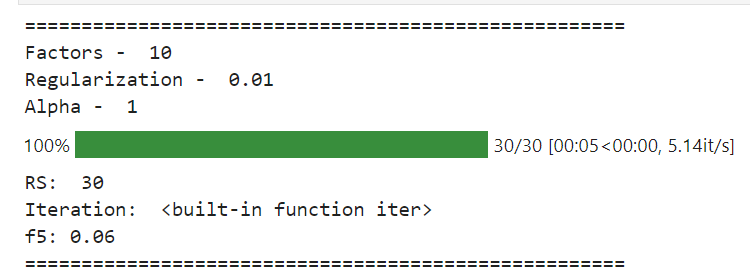

# Results

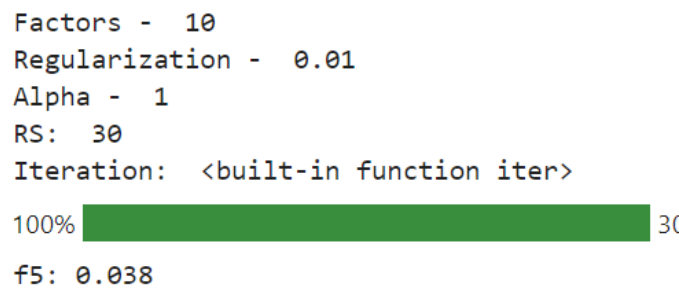

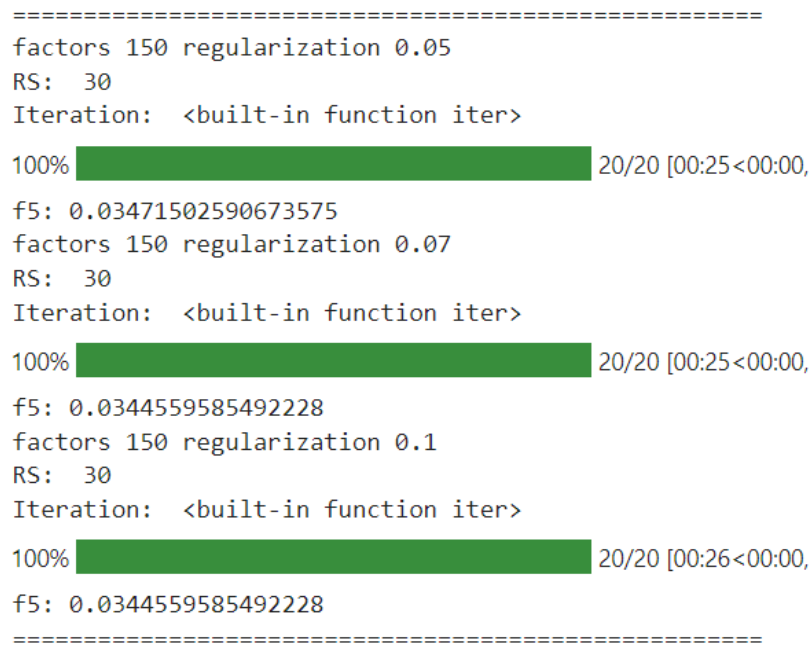

# Colaborative filtering with NN

In [ ]:
np.random.seed(3)
msk = np.random.rand(len(df_new)) < 0.9
train = df_new[msk].copy()
val = df_new[~msk].copy()

# # encoding the train and validation data
df_train,_ = encode_data(train)
df_val,_  = encode_data(val, train)

In [ ]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(MF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        # self.user_emb.weight.data.uniform_(0, 0.05)
        # self.item_emb.weight.data.uniform_(0, 0.05)
        
    def forward(self, u, v):
        u = self.user_emb(u)
        v = self.item_emb(v)
        return (u*v).sum(1)  

In [ ]:
num_users = len(df_train.new_id.unique())
num_items = len(df_train.vacancy_id_.unique())
print(num_users, num_items) 

In [ ]:
model = MF(num_users, num_items, emb_size=100)

def train_epocs(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in tqdm.tqdm(range(epochs)):
        users = torch.LongTensor(df_train.new_id.values)
        items = torch.LongTensor(df_train.vacancy_id_.values)
        ratings = torch.FloatTensor(df_train.ctr.values)
        if unsqueeze:
            ratings = ratings.unsqueeze(1)
        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(loss.item()) 
    test_loss(model, unsqueeze)
    
def test_loss(model, unsqueeze=False):
    model.eval()
    users = torch.LongTensor(df_val.new_id.values)
    items = torch.LongTensor(df_val.vacancy_id_.values)
    ratings = torch.FloatTensor(df_val.ctr.values)
    if unsqueeze:
        ratings = ratings.unsqueeze(1)
    y_hat = model(users, items)
    loss = F.mse_loss(y_hat, ratings)
    # print("test loss %.3f " % loss.item())

In [ ]:
interactions = df.groupby(['new_id', 'vacancy_id_', 'event_type'], as_index=False) \
.agg({'event_timestamp': 'count'}) \
.sort_values(['event_timestamp'], ascending=False)

In [ ]:
# Получить использованные вакансии
def get_not_used_vacancies(new_id):
    used = interactions[interactions['new_id'] == new_id]['vacancy_id_'].unique()
    useful_vacs = list()
    for i in uniq_vacancy:
        if i not in used:
            useful_vacs.append(i)
    return useful_vacs


def get_recommendation(new_test_df):
    df_test, mask = encode_data(new_test_df, train)
    no_pred = new_test_df[~mask].copy()
    new_test_df = new_test_df[mask].copy()

    users = torch.LongTensor(df_test.new_id.values) # .cuda()
    items = torch.LongTensor(df_test.vacancy_id_.values) #.cuda()
    y_hat = model(users, items)
    new_test_df['ctr'] = y_hat.detach().numpy().tolist()
    return new_test_df.sort_values(by=['new_id','ctr'], ascending=False), no_pred

def get_precision(test_df):
    res_df, no_pred = get_recommendation(new_test_df)

    res_df = res_df[res_df.groupby('new_id')['ctr'].rank(method='first', ascending=True) <= 5]
    res_df = res_df.groupby(['new_id'])['vacancy_id_'].agg(['unique'])
    if len(test_df) != len(res_df):
        diff = np.setdiff1d(test_df['new_id'], res_df.index)
        tmp_diff = pd.DataFrame({'unique': [top_vacancies[:5]]*len(diff)}, index=diff)
        res_df = pd.concat([res_df, tmp_diff])
    res_df = res_df.sort_index(ascending=False)

    test_df = test_df.sort_values(by=['new_id'], ascending=False)
    test_df['pred'] = res_df['unique'].values
    
    
    test_df['true_positive'] = test_df.apply(lambda x: len(set(x['vacancy_id_']) & set(x['pred'])), axis=1)
    test_df['f5'] = test_df.apply(lambda x: len(set(x['vacancy_id_']) & set(x['pred'])) / 5, axis=1)
    print('f5: ', test_df['f5'].mean())

In [ ]:
for epoch in [200]:
    for lr in [0.01]:
        model = MF(num_users, num_items, emb_size=100)
        train_epocs(model, epochs=epoch, lr=lr)
        print("Epoch: ", epoch)
        print("Learning rate: ", lr)
        get_precision(test_df)

# Results

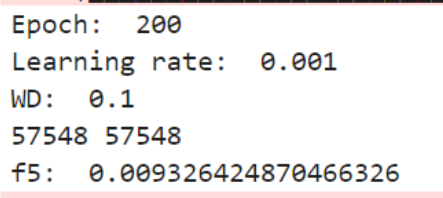

# Private dataset

In [28]:
priv_df = pd.read_parquet('test_private_sample_submission_mfti.parquet', engine='pyarrow')
priv_df['new_id'] = priv_df['cookie_id'].apply(lambda x: get_new_id_by_cookie(x))

In [40]:
priv_df

,cookie_id,predictions,new_id,train_id
0,0018914ba3e54011b28fa715583d3354,"[100100, 100101, 100102, 100103, 100104]",1706e3869fc6432b8d7e04c613fefb4d,28898
1,0035c298d8c64f368ae730a9cca9bb20,"[100100, 100101, 100102, 100103, 100104]",535c21153f7f442bb09de85f0d00dbd6,105105
2,00956458877448ec9fba87fb97443fdf,"[100100, 100101, 100102, 100103, 100104]",9e642ae3300e459f8648e573f105fa43,199343
3,0099387c921b41e7bae6c99dd8254b60,"[100100, 100101, 100102, 100103, 100104]",0c69442f665b4daf8616223323e234a0,15682
4,009f65e8ae99413a8da94a491320580a,"[100100, 100101, 100102, 100103, 100104]",b6ca0d011b3249bf91a59bd4f5f99f6e,230089
...,...,...,...,...
3081,ffadd195859444d2ade2479b0611c5c1,"[100100, 100101, 100102, 100103, 100104]",00f952a5b0d24b9692f7ca9c92001086,1194
3082,ffbc08b528c64f22996873fc63872202,"[100100, 100101, 100102, 100103, 100104]",474c365ecb3845f49cfa2c077c5fa8cc,89888
3083,ffdeaf3c34544529880aebf17c103f6c,"[100100, 100101, 100102, 100103, 100104]",ffdeaf3c34544529880aebf17c103f6c,321868
3084,ffefa79a74804ee69e6c131e0d05b948,"[100100, 100101, 100102, 100103, 100104]",19d988d66b974e24b7f1691e2780b716,32561


In [39]:
priv_df['train_id'] = priv_df.apply(lambda x: mapping[0].get(x['new_id'], -1), axis=1)

In [44]:
def get_recomm(x):
    index = x['train_id']
    if index == -1:
        res = top_vacancies[:5]
    else:
        recomm = model.recommend(index, matrix_for_fact[index], N=5)[0]
    return [i for i,k in mapping[1].items() if k in recomm]

In [45]:
priv_df['pred'] = priv_df.apply(lambda x: get_recomm(x), axis=1)

In [46]:
priv_df[['cookie_id', 'pred']].to_parquet('test_private_sample_predictions.parquet.gzip', compression='gzip') 